In [1]:
import os
import pickle

import numpy as np
import scipy.stats as st
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from npc_sessions import DynamicRoutingSession
import npc_lims

%matplotlib widget

In [2]:
loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\multi_shuffled_blocks"
decoder_results=os.listdir(loadpath)

In [182]:
#combine this with decision function results (cell below)
#table with every switch!
#add: 'decision_function_real', 'decision_function_null', 'before_dprime', 'after_dprime', 'correct_responses'

n_block_repeats=100
trials_before=20
trials_after=30

#separate null results dict?
#average over switches? or just add a row for even each null switch?

results_dict={
    'session_id':[],
    'project':[],
    'structure':[],
    'percentile_95':[],
    'percentile_99':[],
    'diff_in_stdev':[],
    'n_units':[],
    'block_multiplier':[],
    'null_distribution_median':[],
    'null_distribution_std':[],
    'test_distribution_median':[],
    'decision_function_real':[],
    'before_dprime':[],
    'after_dprime':[],
    'correct_responses':[]

}

results_dict_null={
    'session_id':[],
    'project':[],
    'structure':[],
    'n_units':[],
    'block_multiplier':[],
    'decision_function_null':[],
    #doesn't make sense to have behavior for null switches
    # 'before_dprime':[],
    # 'after_dprime':[],
    # 'correct_responses':[]

}

for ff in decoder_results[:]:

    try:
        # ff=decoder_results[0]
        if ff.endswith('.pkl'):
            with open(os.path.join(loadpath,ff),'rb') as handle:
                svc_results=pickle.load(handle)
            print(ff)
        else:
            continue

        #session id
        session_id=svc_results['session_info'].id
        project=svc_results['session_info'].project

        # #behavior data
        # session=DynamicRoutingSession(session_id)
        ## change to load cached trials
        trials=pd.read_parquet(
            npc_lims.get_cache_path('trials',session_id,version='v0.0.173')
        )

        is_correct_response=((trials['is_target'] & trials['is_response']).values | 
                            (trials['is_nontarget'] & ~trials['is_response']).values |
                            ((trials['stim_name']=='catch') & ~trials['is_response']).values)

        #loop over block multipliers
        block_multipliers=[x for x in svc_results.keys() if type(x) is int]
        for block_multiplier in block_multipliers:

            ### NEED TO ALIGN TO PSEUDO SWITCHES FOR EACH SHUFFLE REPEAT!

            # # identify context switches
            # if project=='DynamicRouting':
            #     context_switch_trials=trials.query('is_context_switch')
            #     context_switch_trial_labels=context_switch_trials['context_name'].values=='vis'
            # elif project=='TempletonPilotEphys':
            #     block_labels=svc_results[block_multiplier]['pred_var']
            #     switch_trials_idx=np.where(np.diff(block_labels)!=0)[0]+1
            #     context_switch_trials=trials.iloc[switch_trials_idx]
            #     context_switch_trial_labels=
            
            block_labels=svc_results[block_multiplier]['pred_var']
            switch_trials_idx=np.where(np.diff(block_labels=='vis')!=0)[0]+1
            context_switch_trials=trials.iloc[switch_trials_idx]
            context_switch_trial_labels=block_labels[switch_trials_idx]

            # cross_modal_dprime=session.performance[:]['cross_modal_dprime'].values
            cross_modal_dprime=pd.read_parquet(
                npc_lims.get_cache_path('performance',session_id,version='v0.0.173')
            )['cross_modal_dprime'].values

            #loop over areas
            areas = [x for x in svc_results[block_multiplier].keys() if 'block_index' not in x and 'pred_var' not in x]
            for aa in areas:
                # aa=areas[0]
                n_units=svc_results[block_multiplier][aa]['n_units']

                # collect the data in a useful shape
                all_bal_acc_real=np.full((n_block_repeats),fill_value=np.nan)
                all_bal_acc_pseudo=np.full((n_block_repeats),fill_value=np.nan)

                dec_func_real=[]
                dec_func_null=[]
                for xx in range(0,n_block_repeats):
                    #balanced_accuracy
                    all_bal_acc_real[xx]=svc_results[block_multiplier][aa]['real'][xx]['balanced_accuracy']
                    all_bal_acc_pseudo[xx]=svc_results[block_multiplier][aa]['pseudo'][xx]['balanced_accuracy']

                    #decision function
                    dec_func_real.append(svc_results[block_multiplier][aa]['real'][xx]['decision_function'])
                    dec_func_null.append(svc_results[block_multiplier][aa]['pseudo'][xx]['decision_function'])

                dec_func_real=np.vstack(dec_func_real)
                dec_func_null=np.vstack(dec_func_null)

                # dec_func_real_mean=np.nanmean(dec_func_real,axis=0)/np.nanstd(dec_func_null)
                # dec_func_null_mean=np.nanmean(dec_func_null,axis=0)/np.nanstd(dec_func_null)

                test_median=np.median(all_bal_acc_real)
                null_median=np.median(all_bal_acc_pseudo)
                null_std=np.std(all_bal_acc_pseudo)
                diff_in_std=(test_median-null_median)/null_std
                percentile_95=np.percentile(all_bal_acc_pseudo,95)
                percentile_99=np.percentile(all_bal_acc_pseudo,99)

                #also loop over block repeats for real results
                #loop over pseudo context switches
                for bb in range(0,n_block_repeats):
                    # find block switches for this shuffle
                    label_names=np.array(['aud','vis'])
                    temp_labels_real=svc_results[block_multiplier][aa]['real'][bb]['true_label']
                    switch_trials_idx=np.where(np.diff(temp_labels_real)!=0)[0]+1
                    switch_trials=trials.iloc[switch_trials_idx]
                    switch_trial_labels=label_names[temp_labels_real[switch_trials_idx]]
                    temp_dec_func=svc_results[block_multiplier][aa]['real'][bb]['decision_function']/np.nanstd(dec_func_null)

                    #loop through real context switches
                    for it,(tt,switch_trial) in enumerate(switch_trials.iterrows()):
                        # if (cross_modal_dprime[tt]>=dprime_threshold)&(cross_modal_dprime[tt+1]>=dprime_threshold):
                        if project=='DynamicRouting':
                            results_dict['before_dprime'].append(cross_modal_dprime[it])
                            results_dict['after_dprime'].append(cross_modal_dprime[it+1])
                            results_dict['correct_responses'].append(
                                is_correct_response[switch_trial['trial_index']-trials_before:
                                                    switch_trial['trial_index']+trials_after])
                        else:
                            results_dict['before_dprime'].append(np.nan)
                            results_dict['after_dprime'].append(np.nan)
                            results_dict['correct_responses'].append(np.nan)
                        
                        # if switch_trial['context_name']=='vis':
                        if switch_trial_labels[it]=='vis':
                            results_dict['decision_function_real'].append(
                                temp_dec_func[switch_trial['trial_index']-trials_before:
                                            switch_trial['trial_index']+trials_after])
                        # elif switch_trial['context_name']=='aud':
                        elif switch_trial_labels[it]=='aud':
                            results_dict['decision_function_real'].append(
                                -temp_dec_func[switch_trial['trial_index']-trials_before:
                                            switch_trial['trial_index']+trials_after])
                            
                        else:
                            results_dict['decision_function_real'].append(np.full((trials_before+trials_after),fill_value=np.nan))

                        results_dict['block_multiplier'].append(block_multiplier)
                        results_dict['session_id'].append(session_id)
                        results_dict['project'].append(project)
                        results_dict['structure'].append(aa)
                        results_dict['percentile_95'].append(percentile_95)
                        results_dict['percentile_99'].append(percentile_99)
                        results_dict['diff_in_stdev'].append(diff_in_std)
                        results_dict['n_units'].append(n_units)
                        results_dict['null_distribution_median'].append(null_median)
                        results_dict['test_distribution_median'].append(test_median)
                        results_dict['null_distribution_std'].append(null_std)


                    # append null switches
                    label_names=np.array(['aud','vis'])
                    temp_labels=svc_results[block_multiplier][aa]['pseudo'][bb]['true_label']
                    null_switch_trials_idx=np.where(np.diff(temp_labels)!=0)[0]+1
                    null_switch_trials=trials.iloc[null_switch_trials_idx]
                    null_switch_trial_labels=label_names[temp_labels[null_switch_trials_idx]]
                    temp_dec_func_null=svc_results[block_multiplier][aa]['pseudo'][bb]['decision_function']/np.nanstd(dec_func_null)

                    for it,(tt,switch_trial) in enumerate(null_switch_trials.iterrows()):
                        # if switch_trial['context_name']=='vis':
                        if null_switch_trial_labels[it]=='vis':
                            results_dict_null['decision_function_null'].append(
                                temp_dec_func_null[switch_trial['trial_index']-trials_before:
                                                   switch_trial['trial_index']+trials_after])
                        # elif switch_trial['context_name']=='aud':
                        elif null_switch_trial_labels[it]=='aud':
                            results_dict_null['decision_function_null'].append(
                                -temp_dec_func_null[switch_trial['trial_index']-trials_before:
                                                    switch_trial['trial_index']+trials_after])
                        else:
                            results_dict_null['decision_function_null'].append(np.full((trials_before+trials_after),fill_value=np.nan))

                        results_dict_null['block_multiplier'].append(block_multiplier)
                        results_dict_null['session_id'].append(session_id)
                        results_dict_null['project'].append(project)
                        results_dict_null['structure'].append(aa)
                        results_dict_null['n_units'].append(n_units)

    except Exception as e:
        print(e)
        print(session_id, 'failed')
        continue



620263_2022-07-26_0_multi_shuffled_blocks.pkl
620263_2022-07-27_0_multi_shuffled_blocks.pkl
620264_2022-08-02_0_multi_shuffled_blocks.pkl
626791_2022-08-15_0_multi_shuffled_blocks.pkl
626791_2022-08-17_0_multi_shuffled_blocks.pkl
628801_2022-09-19_0_multi_shuffled_blocks.pkl
636397_2022-09-26_0_multi_shuffled_blocks.pkl
636397_2022-09-27_0_multi_shuffled_blocks.pkl
636766_2023-01-23_0_multi_shuffled_blocks.pkl
636766_2023-01-24_0_multi_shuffled_blocks.pkl
636766_2023-01-25_0_multi_shuffled_blocks.pkl
636766_2023-01-26_0_multi_shuffled_blocks.pkl
644547_2022-12-05_0_multi_shuffled_blocks.pkl
644547_2022-12-06_0_multi_shuffled_blocks.pkl
644864_2023-01-30_0_multi_shuffled_blocks.pkl
644864_2023-01-31_0_multi_shuffled_blocks.pkl
644864_2023-02-01_0_multi_shuffled_blocks.pkl
644864_2023-02-02_0_multi_shuffled_blocks.pkl
644866_2023-02-07_0_multi_shuffled_blocks.pkl
644866_2023-02-09_0_multi_shuffled_blocks.pkl
644866_2023-02-10_0_multi_shuffled_blocks.pkl
644867_2023-02-20_0_multi_shuffled

In [ ]:
# temp_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [124]:
# label_names=np.array(['vis','aud'])
# temp_labels=svc_results[block_multiplier][aa]['pseudo'][xx]['true_label']
# null_switch_trials_idx=np.where(np.diff(temp_labels)!=0)[0]+1
# null_switch_trials=trials.iloc[null_switch_trials_idx]
# null_switch_trial_labels=label_names[temp_labels[null_switch_trials_idx]]
# temp_dec_func_null=svc_results[block_multiplier][aa]['pseudo'][bb]['decision_function']

In [125]:
null_switch_trial_labels

array(['aud', 'vis', 'aud', 'vis', 'aud', 'vis', 'aud', 'vis', 'aud'],
      dtype='<U3')

In [190]:
results_dict['before_dprime']=results_dict['before_dprime'][1:]

In [187]:
for key in results_dict.keys():
    print(key,len(results_dict[key]))

session_id 2928003
project 2928003
structure 2928003
percentile_95 2928003
percentile_99 2928003
diff_in_stdev 2928003
n_units 2928003
block_multiplier 2928003
null_distribution_median 2928003
null_distribution_std 2928003
test_distribution_median 2928003
decision_function_real 2928003
before_dprime 2928004
after_dprime 2928003
correct_responses 2928003


In [191]:
results_df=pd.DataFrame(results_dict)
results_null_df=pd.DataFrame(results_dict_null)

# results_df.to_csv(os.path.join(savepath,'decoding_results.csv'))
# results_null_df.to_csv(os.path.join(savepath,'decoding_results_null.csv'))

In [192]:
#try saving as pkl - more efficient? timewise and spacewise?
savepath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\multi_shuffled_blocks\processed"
with open(os.path.join(savepath,'decoding_results.pkl'),'wb') as handle: 
    pickle.dump(results_dict,handle)
with open(os.path.join(savepath,'decoding_results_null.pkl'),'wb') as handle:
    pickle.dump(results_dict_null,handle)


In [193]:
results_df

,session_id,project,structure,percentile_95,percentile_99,diff_in_stdev,n_units,block_multiplier,null_distribution_median,null_distribution_std,test_distribution_median,decision_function_real,before_dprime,after_dprime,correct_responses
0,620263_2022-07-26,TempletonPilotSession,all,0.967120,0.970280,-1.549786,1026,1,0.855554,0.065326,0.754313,"[-0.6186978160656668, -1.0400064472674275, 0.2...",NaN,NaN,NaN
1,620263_2022-07-26,TempletonPilotSession,all,0.967120,0.970280,-1.549786,1026,1,0.855554,0.065326,0.754313,"[-0.015653597035469088, 0.026709620710759094, ...",NaN,NaN,NaN
2,620263_2022-07-26,TempletonPilotSession,all,0.967120,0.970280,-1.549786,1026,1,0.855554,0.065326,0.754313,"[-0.4991484364387052, -0.8922872071098735, -0....",NaN,NaN,NaN
3,620263_2022-07-26,TempletonPilotSession,all,0.967120,0.970280,-1.549786,1026,1,0.855554,0.065326,0.754313,"[-0.4994383047472139, -0.010401744888109715, 0...",NaN,NaN,NaN
4,620263_2022-07-26,TempletonPilotSession,all,0.967120,0.970280,-1.549786,1026,1,0.855554,0.065326,0.754313,"[-1.074709911989321, -0.46290027996023736, -0....",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927998,681532_2023-10-18,DynamicRouting,VISpm,0.573106,0.581357,1.738453,35,10,0.518513,0.032705,0.575369,"[0.17095903252664277, -1.474556998585597, -0.1...",2.634454,2.077642,"[True, True, True, True, True, False, True, Tr..."
2927999,681532_2023-10-18,DynamicRouting,VISpm,0.573106,0.581357,1.738453,35,10,0.518513,0.032705,0.575369,"[0.31183986272264447, 0.7401250931618498, -0.2...",2.077642,2.801652,"[True, True, True, True, True, True, True, Tru..."
2928000,681532_2023-10-18,DynamicRouting,VISpm,0.573106,0.581357,1.738453,35,10,0.518513,0.032705,0.575369,"[0.1871283022174151, 2.257076956453519, -0.071...",2.801652,2.455901,"[True, True, True, True, True, True, True, Tru..."
2928001,681532_2023-10-18,DynamicRouting,VISpm,0.573106,0.581357,1.738453,35,10,0.518513,0.032705,0.575369,"[4.589083271030669, 0.5788393684503759, -0.208...",2.455901,2.588996,"[True, True, True, True, True, True, True, Fal..."


In [194]:
results_null_df

,session_id,project,structure,n_units,block_multiplier,decision_function_null
0,620263_2022-07-26,TempletonPilotSession,all,1026,1,"[-1.059773526728168, 0.1704989418313566, -1.06..."
1,620263_2022-07-26,TempletonPilotSession,all,1026,1,"[-0.5240175934660988, 0.0987755017302024, 0.64..."
2,620263_2022-07-26,TempletonPilotSession,all,1026,1,"[-0.8043659304264162, -0.45008200349503336, 0...."
3,620263_2022-07-26,TempletonPilotSession,all,1026,1,"[-0.7885960574295894, 0.1807364192627242, 0.09..."
4,620263_2022-07-26,TempletonPilotSession,all,1026,1,"[-0.7251040550666128, -0.4338703132383317, -0...."
...,...,...,...,...,...,...
7308678,681532_2023-10-18,DynamicRouting,VISpm,35,10,"[1.196599455179475, -2.6441055195668213, -0.07..."
7308679,681532_2023-10-18,DynamicRouting,VISpm,35,10,"[-0.42542515584175, 0.5695686177317401, -1.500..."
7308680,681532_2023-10-18,DynamicRouting,VISpm,35,10,"[0.6250844639070318, 0.6635368131267431, -4.58..."
7308681,681532_2023-10-18,DynamicRouting,VISpm,35,10,"[-0.6558889645086566, -0.6774340461829849, 1.3..."


In [143]:
results_df['structure'].unique()

array(['all', 'CP_probeA', 'ProS_probeC', 'SSp', 'MOs', 'CP_probeF', 'PO',
       'RSPagl', 'VISp', 'CA3_probeD', 'AUDd', 'VISli', 'CA1_probeD',
       'CA1_probeB', 'LP_probeB', 'VISpor', 'CA1_probeE', 'CA3_probeE',
       'DG_probeD', 'ProS_probeD', 'POL', 'DG_probeB', 'VISpm'],
      dtype=object)

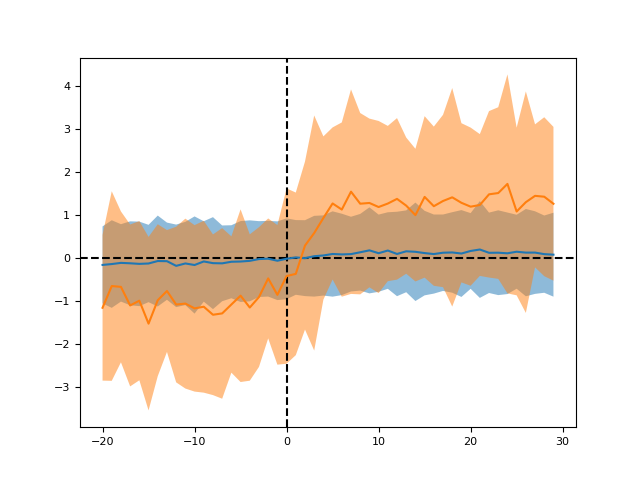

In [198]:
block_multiplier=3
sel_area='ORB'

sel_project='DynamicRouting' #'TempletonPilotSession' or 'DynamicRouting'

temp_dec_func=results_df.query('block_multiplier==@block_multiplier & structure.str.contains(@sel_area) & project==@sel_project')['decision_function_real'].values
lengths=[]
for xx in range(0,len(temp_dec_func)):
    lengths.append(len(temp_dec_func[xx]))
real_dec_func=np.vstack(temp_dec_func[np.array(lengths)==np.max(lengths)])

#remove switches with different lengths
temp_dec_func_null=results_null_df.query('block_multiplier==@block_multiplier & structure.str.contains(@sel_area) & project==@sel_project')['decision_function_null'].values
lengths=[]
for xx in range(0,len(temp_dec_func_null)):
    lengths.append(len(temp_dec_func_null[xx]))
null_dec_func=np.vstack(temp_dec_func_null[np.array(lengths)==np.max(lengths)])

fig,ax=plt.subplots()
ax.axhline(0,color='k',linestyle='--')
ax.axvline(0,color='k',linestyle='--')
ax.plot(np.arange(-20,30),np.nanmean(null_dec_func,axis=0))
ax.fill_between(np.arange(-20,30),np.nanmean(null_dec_func,axis=0)-np.nanstd(null_dec_func,axis=0),
                np.nanmean(null_dec_func,axis=0)+np.nanstd(null_dec_func,axis=0),alpha=0.5)
ax.plot(np.arange(-20,30),np.nanmean(real_dec_func,axis=0))
ax.fill_between(np.arange(-20,30),np.nanmean(real_dec_func,axis=0)-np.nanstd(real_dec_func,axis=0),
                np.nanmean(real_dec_func,axis=0)+np.nanstd(real_dec_func,axis=0),alpha=0.5)

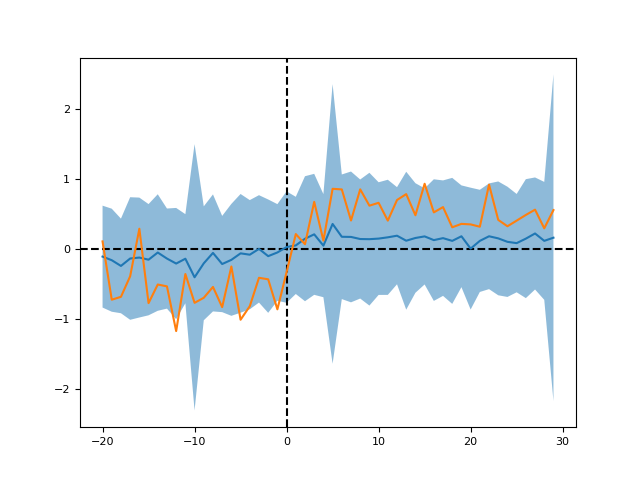

In [181]:
fig,ax=plt.subplots()
ax.axhline(0,color='k',linestyle='--')
ax.axvline(0,color='k',linestyle='--')
ax.plot(np.arange(-20,30),np.nanmean(null_dec_func,axis=0))
ax.fill_between(np.arange(-20,30),np.nanmean(null_dec_func,axis=0)-np.nanstd(null_dec_func,axis=0),
                np.nanmean(null_dec_func,axis=0)+np.nanstd(null_dec_func,axis=0),alpha=0.5)
ax.plot(np.arange(-20,30),np.nanmean(real_dec_func,axis=0))

In [ ]:
# for both Templeton and DR recordings:

# plot MOs switches - null w/ 95% confidence interval

# plot MOs switches - real

In [74]:
lengths=[]
temp=results_null_df.query('block_multiplier==@block_multiplier & structure==@sel_area & project=="TempletonPilotSession"')['decision_function_null'].values

for xx in range(0,len(temp)):
    lengths.append(len(temp[xx]))

In [118]:
context_switch_trials

,start_time,stop_time,quiescent_start_time,quiescent_stop_time,stim_start_time,stim_stop_time,response_window_start_time,response_window_stop_time,task_control_response_time,response_time,...,is_aud_nontarget,is_vis_nontarget,is_vis_context,is_aud_context,is_context_switch,is_repeat,is_opto,session_idx,date,subject_id
id,,,,,,,,,,,,,,,,,,,,,
109,690.31194,694.84900,690.31194,691.849490,691.849490,692.849490,691.91326,692.84735,NaN,NaN,...,True,False,True,False,False,False,False,0,2022-07-26,620263
229,1288.87427,1293.41138,1288.87427,1290.439477,1290.439477,1291.190023,1290.49229,1291.40976,NaN,NaN,...,False,True,True,False,False,False,False,0,2022-07-26,620263
340,1888.65454,1893.19140,1888.65454,1890.202737,1890.202737,1890.703157,1890.25554,1891.17303,NaN,NaN,...,False,True,True,False,False,False,False,0,2022-07-26,620263
456,2487.61693,2492.17074,2487.61693,2489.157158,2489.157158,2490.157158,2489.21821,2490.15236,NaN,NaN,...,True,False,True,False,False,False,False,0,2022-07-26,620263
561,3041.37547,3045.92928,3041.37547,3042.940567,3042.940567,3043.440977,3042.99393,3043.91088,NaN,NaN,...,False,True,True,False,False,False,False,0,2022-07-26,620263


In [91]:
temp_dec_func

array([array([-1.61454243, -1.26135423, -0.84094591, -1.63811101, -1.27002147,
              -0.15483623, -1.30826323, -0.85276141, -1.04534631, -1.19442313,
              -0.32486459, -1.09728492, -0.61592955, -0.93554684, -1.21673533,
              -0.67018844, -0.64984527, -0.58173504, -1.04645041, -0.2337294 ,
              -1.39346738, -0.68004421, -0.87291031, -0.34561803, -0.30643692,
               0.27610745, -0.49248259,  0.31567863, -0.60304305,  0.05813283,
               0.03324753,  0.00534996, -0.34076612,  0.01869018,  0.2801461 ,
              -0.46456136, -0.96406776, -0.23656441, -0.53661642, -1.67086082,
               0.50012176,  0.26008488, -0.0530516 , -0.7236976 , -0.50953188,
               0.07622822, -0.3449335 , -0.48827999,  1.30701202, -0.1504885 ]),
       array([-0.91628661, -1.44467132, -0.30971753, -1.02940286,  0.14865463,
              -1.14408388,  0.1797392 , -0.31337754, -1.86130097,  0.20703296,
              -0.84120426, -1.53216618,  0.1337765

In [106]:
block_labels

NameError: name 'block_labels' is not defined